# ECG5000 – D-SVM Control Chart Experiment (TEST)

This notebook provides the preprocessing steps for the ECG5000 dataset before running D-SVM and DTW-based experiments. Preprocessing functions are imported from src/dsvm/data_prep.py, and alignment utilities are imported from src/dsvm/alignment.py.

Main tasks in this notebook:

1. Load the raw ECG5000 TRAIN and TEST files.

2. Split the data into in-control (class 1) and out-of-control (classes 2–5).

3. Apply z-normalization to each time series.

4. Generate time-shifted versions of the data.

5. Compute class-wise mean curves for pattern comparison.

6. Visualize Euclidean and DTW alignments to highlight temporal distortions.

This notebook simply records each step of the preprocessing pipeline in a clear and reproducible way.


In [5]:
from scipy.spatial.distance import euclidean
from dtaidistance import dtw
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# 경로 설정
NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_RAW_DIR = PROJECT_ROOT / "data" / "raw"
DATA_PROC_DIR = PROJECT_ROOT / "data" / "processed"

DATA_PROC_DIR.mkdir(parents=True, exist_ok=True)

# src 폴더를 파이썬 검색 경로에 추가
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

print("Notebook dir:", NOTEBOOK_DIR)
print("Project root:", PROJECT_ROOT)
print("Data raw dir:", DATA_RAW_DIR)
print("Data processed dir:", DATA_PROC_DIR)
print("Src dir:", SRC_DIR)

Notebook dir: C:\Users\siam2\Desktop\dsvm-dtw\experiments
Project root: C:\Users\siam2\Desktop\dsvm-dtw
Data raw dir: C:\Users\siam2\Desktop\dsvm-dtw\data\raw
Data processed dir: C:\Users\siam2\Desktop\dsvm-dtw\data\processed
Src dir: C:\Users\siam2\Desktop\dsvm-dtw\src


# ECG5000
Train Size : 500  
Test Size : 4500  
Length : 140  
Number of Classes : 5  (클래스 1 : Normal heartbeat, 2~5 : 비정상 패턴)  
Number of Dimensions : 1(univariate time series)  
Type : ECG    

한 명의 환자(record "chf07")의 ECG 신호에서 추출한 5000개의 heartbeat 시계열이며, 시계열 분류 성능 테스트를 위한 전처리된 벤치마크 데이터셋  

# ECG5000 클래스 요약

| 클래스 번호 | 영어 이름                                                        | 한글 이름                                   |
|-------------|------------------------------------------------------------------|-------------------------------------------|
| Class 1     | N (Normal)                                                      | 정상 박동 / 정상 심장 박동                 |
| Class 2     | R-on-T (R-on-T Premature Ventricular Contraction)               | R-on-T 심실 조기 수축 (심각한 부정맥 유형) |
| Class 3     | PVC (Premature Ventricular Contraction)                         | 심실 조기 수축 (PVC)                      |
| Class 4     | SP (Supraventricular Premature Beat)                            | 심방성 조기 수축 (SP) / 심방 조기박동     |
| Class 5     | UB (Unclassified Beat)                                          | 미분류 박동 / 분류되지 않은 심장 박동     |


In [6]:
from dsvm.data_prep import (
    load_ecg5000,
    split_in_out,
    z_norm_each_series,
    apply_global_shift_segment_mean,   
    compute_class_mean_curves,
)

from dsvm.alignment import (
    shift_series_time,
    compute_dtw_distance_and_path,
    compute_euclidean_alignment,
    plot_alignment,
    plot_euclidean_and_dtw_alignment,
)


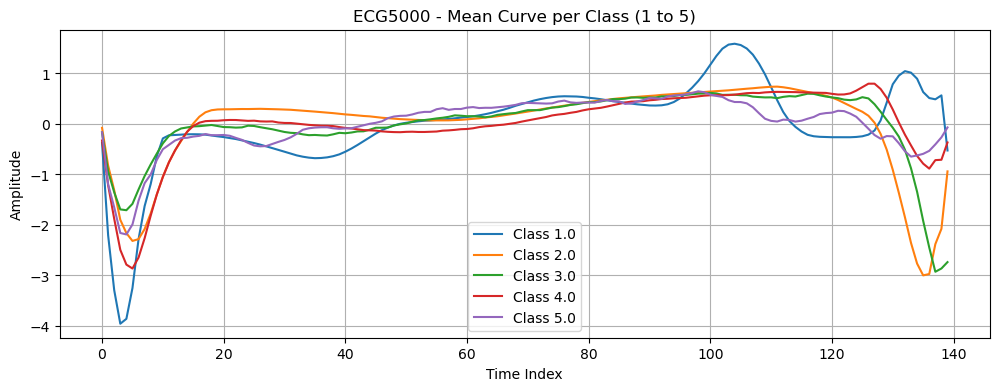

In [7]:
# 데이터 로딩
train_raw, test_raw = load_ecg5000(DATA_RAW_DIR)
full_data = pd.concat([train_raw, test_raw], ignore_index=True)

# mean curve 계산
mean_curves = compute_class_mean_curves(full_data)

# 시각화
plt.figure(figsize=(12, 4))
for label, mean_curve in mean_curves.items():
    plt.plot(mean_curve.values, label=f'Class {label}')

plt.title("ECG5000 - Mean Curve per Class (1 to 5)")
plt.xlabel("Time Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

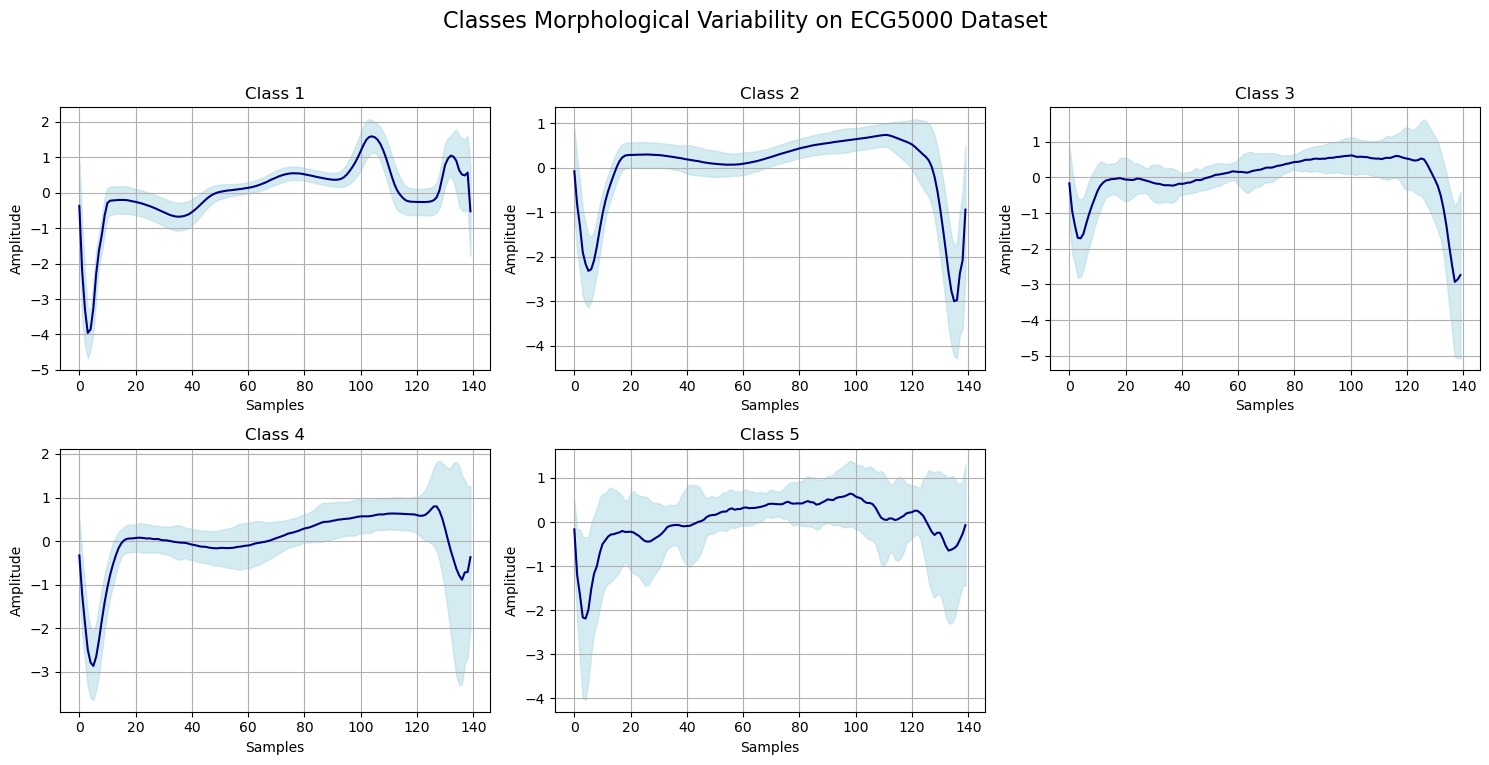

In [8]:
# 클래스별 평균 및 표준편차 시각화
labels = [1, 2, 3, 4, 5]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, label in enumerate(labels):
    class_data = full_data[full_data[0] == label].iloc[:, 1:]
    mean_curve = class_data.mean(axis=0)
    std_curve = class_data.std(axis=0)

    x = np.arange(mean_curve.shape[0])
    axes[idx].plot(x, mean_curve, color='navy', label='Mean')
    axes[idx].fill_between(x, mean_curve - std_curve, mean_curve + std_curve, color='lightblue', alpha=0.5, label='±1 Std')
    axes[idx].set_title(f'Class {label}')
    axes[idx].set_xlabel('Samples')
    axes[idx].set_ylabel('Amplitude')
    axes[idx].grid(True)

# 마지막 빈 그래프 제거 (2x3 중 5개만 사용)
if len(labels) < len(axes):
    fig.delaxes(axes[-1])

plt.suptitle('Classes Morphological Variability on ECG5000 Dataset', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [9]:
# 데이터셋 분할
train_incontrol, test_incontrol, test_outcontrol = split_in_out(
    train_raw,
    test_raw,
    incontrol_label=1,
    seed=1,
)

# 데이터셋 크기 출력
print(f"train_incontrol: {train_incontrol.shape}")
print(f"test_incontrol:  {test_incontrol.shape}")
print(f"test_outcontrol: {test_outcontrol.shape}")

train_incontrol: (1459, 140)
test_incontrol:  (1460, 140)
test_outcontrol: (1873, 140)


In [10]:
# Z-normalization
train_incontrol = pd.DataFrame(
    z_norm_each_series(train_incontrol.values),
    index=train_incontrol.index,
    columns=train_incontrol.columns
)

test_incontrol = pd.DataFrame(
    z_norm_each_series(test_incontrol.values),
    index=test_incontrol.index,
    columns=test_incontrol.columns
)

test_outcontrol = pd.DataFrame(
    z_norm_each_series(test_outcontrol.values),
    index=test_outcontrol.index,
    columns=test_outcontrol.columns
)

In [11]:
# 데이터 저장
train_incontrol.to_csv(DATA_PROC_DIR / "ecg5000_train_incontrol_original.csv", index=False)
test_incontrol.to_csv(DATA_PROC_DIR / "ecg5000_test_incontrol_original.csv", index=False)
test_outcontrol.to_csv(DATA_PROC_DIR / "ecg5000_test_outcontrol_original.csv", index=False)

In [12]:
# 시프트된 데이터 생성

shift_range = 10  # 시프트 범위 설정
rng = np.random.default_rng(0)  # 재현 가능하게 seed 설정

X_train = train_incontrol.values  # (n_train, T)
X_train_shifted, train_shifts = apply_global_shift_segment_mean(
    X_train,
    shift_range=shift_range,
    rng=rng
)

train_incontrol_shifted_df = pd.DataFrame(
    X_train_shifted,
    index=train_incontrol.index,
    columns=train_incontrol.columns
)

In [13]:
# test in-control
rng = np.random.default_rng(1)
X_test_ic = test_incontrol.values

X_test_ic_shifted, test_ic_shifts = apply_global_shift_segment_mean(
    X_test_ic,
    shift_range=shift_range,
    rng=rng
)

test_incontrol_shifted_df = pd.DataFrame(
    X_test_ic_shifted,
    index=test_incontrol.index,
    columns=test_incontrol.columns
)

In [14]:
# test out-of-control
rng = np.random.default_rng(2)
X_test_oc = test_outcontrol.values

X_test_oc_shifted, test_oc_shifts = apply_global_shift_segment_mean(
    X_test_oc,
    shift_range=shift_range,
    rng=rng
)

test_outcontrol_shifted_df = pd.DataFrame(
    X_test_oc_shifted,
    index=test_outcontrol.index,
    columns=test_outcontrol.columns
)

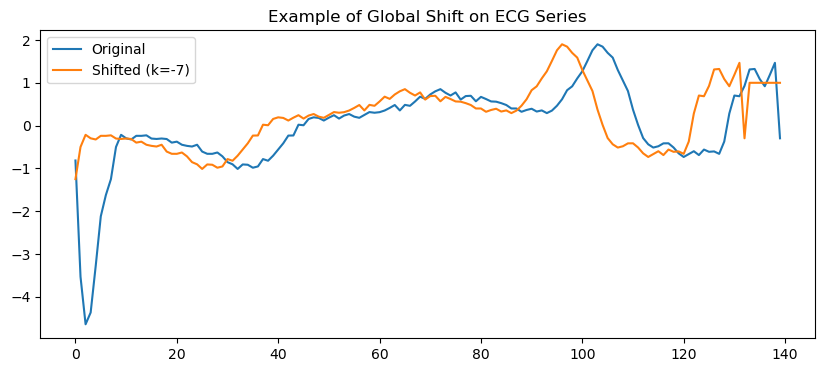

In [15]:
rng = np.random.default_rng(13)
idx = rng.choice(train_incontrol_shifted_df.shape[0], size=1)[0]

plt.figure(figsize=(10, 4))
plt.plot(train_incontrol.iloc[idx].values, label="Original")
plt.plot(train_incontrol_shifted_df.iloc[idx].values, label=f"Shifted (k={train_shifts[idx]})")
plt.legend()
plt.title("Example of Global Shift on ECG Series")
plt.show()

Euclidean cost: 9.5817


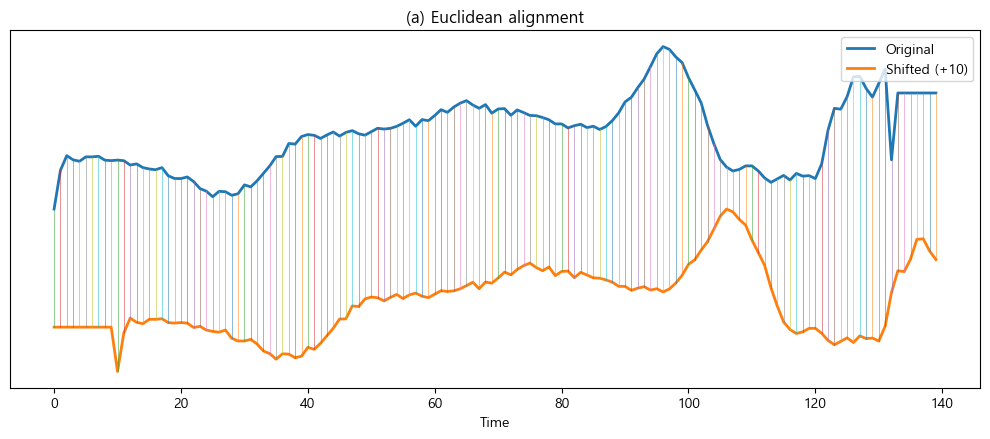

DTW cost: 1.7649


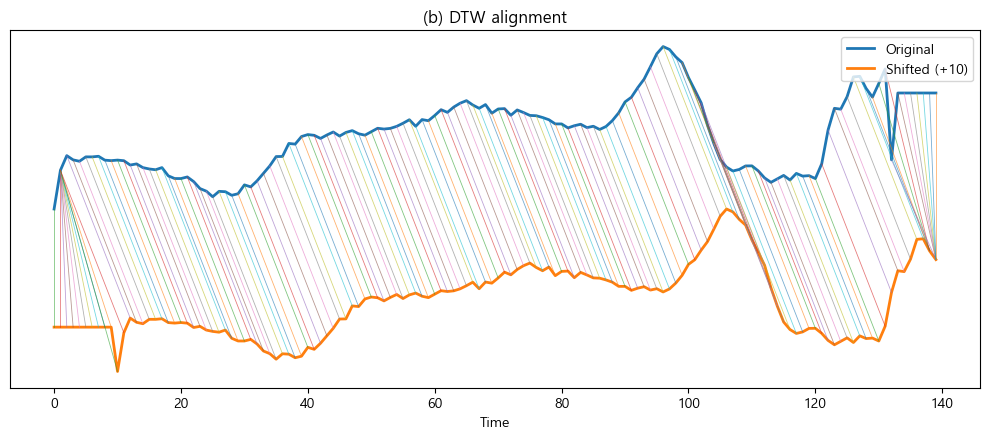

In [16]:
# 폰트 설정은 노트북에서
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# 시계열 하나 뽑기
rng = np.random.default_rng(13)
idx = rng.choice(train_incontrol_shifted_df.shape[0], size=1)[0]
ts = train_incontrol_shifted_df.iloc[idx].values

# 유클리디안 vs DTW 정렬 비교
plot_euclidean_and_dtw_alignment(
    ts,
    shift=10,      # +10 타임 시프트
    window=20      # DTW window (원하면 None으로)
)

In [17]:
train_incontrol_shifted_df.to_csv(
    DATA_PROC_DIR / f"ecg5000_train_incontrol_shift_{shift_range}.csv", index=False
)
test_incontrol_shifted_df.to_csv(
    DATA_PROC_DIR / f"ecg5000_test_incontrol_shift_{shift_range}.csv", index=False
)
test_outcontrol_shifted_df.to_csv(
    DATA_PROC_DIR / f"ecg5000_test_outcontrol_shift_{shift_range}.csv", index=False
) 

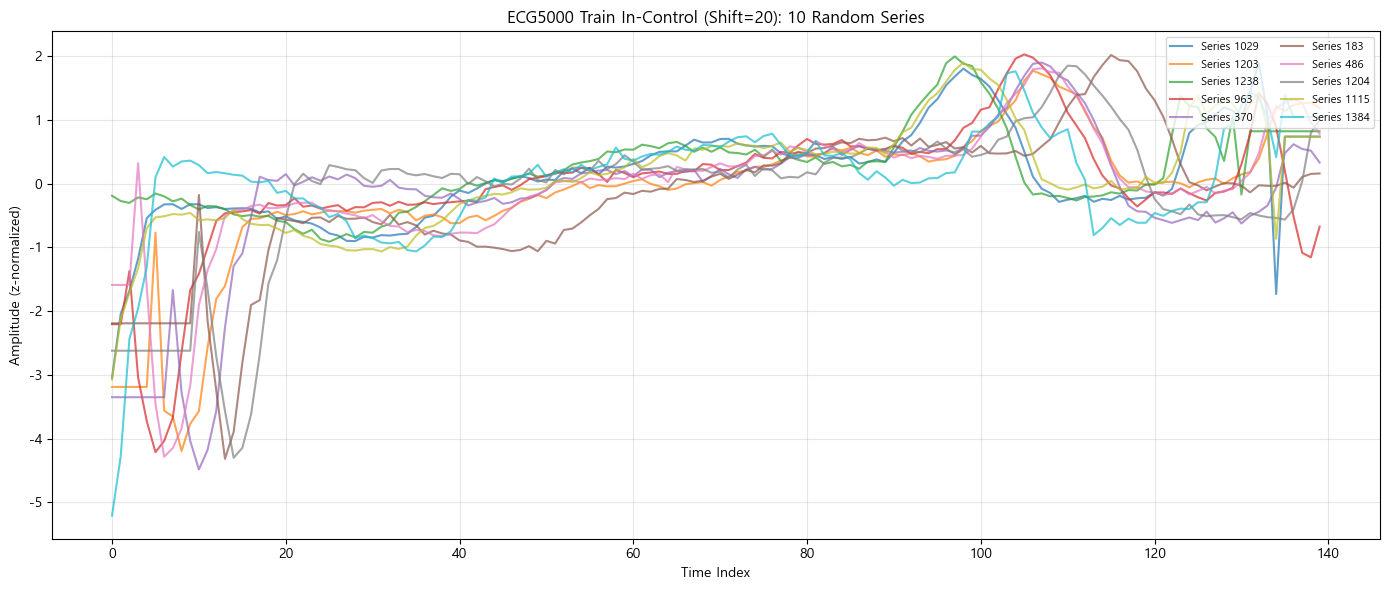

Selected indices: [183, 370, 486, 963, 1029, 1115, 1203, 1204, 1238, 1384]


In [19]:
# ecg5000_train_incontrol_shift_20.csv에서 랜덤으로 데이터 10개 선택해서 동시에 시각화
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSV 파일 로드
csv_path = DATA_PROC_DIR / "ecg5000_train_incontrol_shift_10.csv"
df = pd.read_csv(csv_path)

# 랜덤 시드 설정 (재현 가능성)
rng = np.random.default_rng(41)

# 랜덤으로 10개 인덱스 선택
n_samples = min(10, df.shape[0])
random_indices = rng.choice(df.shape[0], size=n_samples, replace=False)

# 시각화
plt.figure(figsize=(14, 6))
for idx in random_indices:
    series = df.iloc[idx].values
    plt.plot(series, alpha=0.7, label=f'Series {idx}')

plt.title('ECG5000 Train In-Control (Shift=20): 10 Random Series')
plt.xlabel('Time Index')
plt.ylabel('Amplitude (z-normalized)')
plt.legend(loc='upper right', fontsize=8, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Selected indices: {sorted(random_indices)}")
